Install the ChEMBL web service package so that we can retrieve bioactivity data from the ChEMBL Database.

In [1]:
# ! pip install chembl_webresource_client

Import libraries

In [2]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

Our target is CD73

In [3]:
target = new_client.target
target_query = target.search('CD73')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P21589', 'xref_name': None, 'xre...",Homo sapiens,5'-nucleotidase,13.0,False,CHEMBL5957,"[{'accession': 'P21589', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P21588', 'xref_name': None, 'xre...",Rattus norvegicus,5'-nucleotidase,13.0,False,CHEMBL1075214,"[{'accession': 'P21588', 'component_descriptio...",SINGLE PROTEIN,10116
2,[],Mus musculus,5'-nucleotidase,13.0,False,CHEMBL4680034,"[{'accession': 'Q61503', 'component_descriptio...",SINGLE PROTEIN,10090


Let's use the human one

In [4]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL5957'

Let's retrieve all the molecule that has activity with our target and we filter for IC50

In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [6]:
df = pd.DataFrame.from_dict(res)
df.assay_description.unique()

array(["Inhibition of human recombinant ecto-5'-nucleotidase expressed in african green monkey COS7 cells using adenosine monophosphate as substrate preincubated for 10 mins before substrate addition measured after 10 mins by capillary electrophoresis",
       "Inhibition of human Ecto-5'-nucleotidase transfected in COS7 cells preincubated for 10 mins followed by AMP addition measured after 10 mins",
       'Inhibition of human flag-tagged CD73 Thr376Ala mutant (1 to 552 residues) assessed as reduction in conversion of AMP to adenosine incubated for 10 mins followed by AMP addition measured after 30 mins by RapidFire mass spectrometric analysis',
       'Inhibition of CD73 in human NCI-H292 cells assessed as reduction in conversion of AMP to adenosine incubated for 30 mins by malachite green reagent based assay',
       'Inhibition of CD73 in human MDA-MB-231 cells assessed as reduction in conversion of AMP to adenosine incubated for 30 mins by malachite green reagent based assay',
   

In [7]:
df.shape

(344, 46)

In [8]:
df = df[df.standard_value.notna()]
df.shape

(341, 46)

In [9]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df = df[selection]
df

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL68253,NS(=O)(=O)O,42100.0
1,CHEMBL1339340,Cc1ccc2nc(-c3ccc(N)cc3)sc2c1S(=O)(=O)O,13500.0
2,CHEMBL3088000,CC1=NN(c2ccc(S(=O)(=O)O)cc2)C(=O)C1,6100.0
3,CHEMBL3087999,Nc1c(O)cc(S(=O)(=O)O)c2cc([N+](=O)[O-])ccc12,41000.0
4,CHEMBL3087998,Nc1ccc(Nc2ccc([N+](=O)[O-])cc2)c(S(=O)(=O)O)c1,47600.0
...,...,...,...
339,CHEMBL5190085,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,5690.0
340,CHEMBL5207600,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,37190.0
341,CHEMBL5177276,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,1390.0
342,CHEMBL5187845,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,100000.0


LIPINSKI VARIABLES

In [10]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [11]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"] 
    # peso molecolare, coeffigiente di partizione, numero di donatori di idrogeno, numero di accettori di idrogeno  
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [12]:
df_lipinski = lipinski(df.canonical_smiles)

In [13]:
df_combined = pd.concat([df,df_lipinski], axis=1)  
df_combined = df_combined.dropna()
df_combined.info()


<class 'pandas.core.frame.DataFrame'>
Index: 338 entries, 0 to 340
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  338 non-null    object 
 1   canonical_smiles    338 non-null    object 
 2   standard_value      338 non-null    object 
 3   MW                  338 non-null    float64
 4   LogP                338 non-null    float64
 5   NumHDonors          338 non-null    float64
 6   NumHAcceptors       338 non-null    float64
dtypes: float64(4), object(3)
memory usage: 21.1+ KB


ADD INIBITORY CONCENTRATION 50 log and non

In [14]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def Inhibitory_Concentration_50(input):
    pIC50 = []
    IC50 = []

    for i in input['standard_value_norm']:
        molar = float(i) * (10 ** -9)  # Converts nM to M
        pIC50.append(-np.log10(molar))

    for i in input['standard_value_norm']:
        molar = float(i)*(10**-9) 
        IC50.append(molar)

    input['IC50'] = IC50
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)  
        
    return x


In [15]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if float(i) > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)
        
    return x

In [16]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL68253,NS(=O)(=O)O,97.095,-1.25210,2.0,2.0,42100.0
1,CHEMBL1339340,Cc1ccc2nc(-c3ccc(N)cc3)sc2c1S(=O)(=O)O,320.395,3.10062,2.0,5.0,13500.0
2,CHEMBL3088000,CC1=NN(c2ccc(S(=O)(=O)O)cc2)C(=O)C1,254.267,1.04590,1.0,4.0,6100.0
3,CHEMBL3087999,Nc1c(O)cc(S(=O)(=O)O)c2cc([N+](=O)[O-])ccc12,284.249,1.28250,3.0,6.0,41000.0
4,CHEMBL3087998,Nc1ccc(Nc2ccc([N+](=O)[O-])cc2)c(S(=O)(=O)O)c1,309.303,2.16730,3.0,6.0,47600.0
...,...,...,...,...,...,...,...
336,CHEMBL5170776,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,541.817,8.23180,2.0,3.0,100000.0
337,CHEMBL5185215,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,543.789,6.81570,3.0,4.0,16810.0
338,CHEMBL5207447,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,567.855,8.71970,1.0,3.0,81430.0
339,CHEMBL5190085,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,582.870,7.48120,1.0,4.0,5690.0


una piccola IC50 indica che il composto è più potente, poiché è necessaria una minore concentrazione per ottenere un effetto significativo.
più è grande pIC50 e più è potente

In [17]:
df_final = Inhibitory_Concentration_50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,IC50,pIC50
0,CHEMBL68253,NS(=O)(=O)O,97.095,-1.25210,2.0,2.0,0.000042,4.375718
1,CHEMBL1339340,Cc1ccc2nc(-c3ccc(N)cc3)sc2c1S(=O)(=O)O,320.395,3.10062,2.0,5.0,0.000014,4.869666
2,CHEMBL3088000,CC1=NN(c2ccc(S(=O)(=O)O)cc2)C(=O)C1,254.267,1.04590,1.0,4.0,0.000006,5.214670
3,CHEMBL3087999,Nc1c(O)cc(S(=O)(=O)O)c2cc([N+](=O)[O-])ccc12,284.249,1.28250,3.0,6.0,0.000041,4.387216
4,CHEMBL3087998,Nc1ccc(Nc2ccc([N+](=O)[O-])cc2)c(S(=O)(=O)O)c1,309.303,2.16730,3.0,6.0,0.000048,4.322393
...,...,...,...,...,...,...,...,...
336,CHEMBL5170776,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,541.817,8.23180,2.0,3.0,0.000100,4.000000
337,CHEMBL5185215,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,543.789,6.81570,3.0,4.0,0.000017,4.774432
338,CHEMBL5207447,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,567.855,8.71970,1.0,3.0,0.000081,4.089216
339,CHEMBL5190085,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,582.870,7.48120,1.0,4.0,0.000006,5.244888


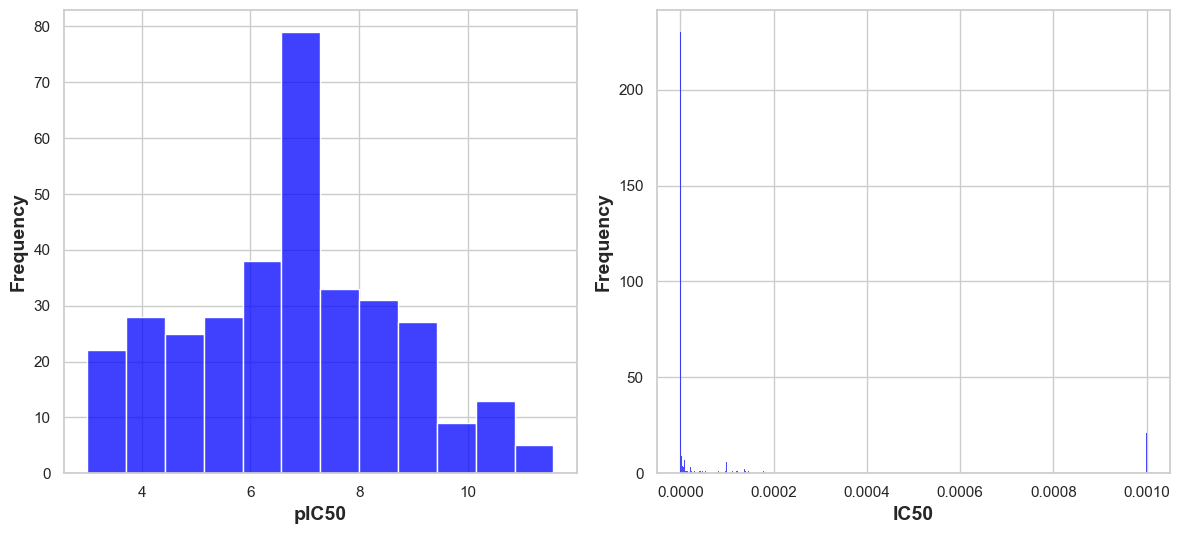

In [18]:
#difference of distribution between the clumn IC50 and pIC50
import seaborn as sns
import matplotlib.pyplot as plt

# Setting style and figure size
sns.set(style='whitegrid')
plt.figure(figsize=(12, 5.5))

# Plotting histogram for pIC50
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(df_final['pIC50'], kde=False, color='blue')
plt.xlabel('pIC50', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Plotting histogram for IC50 from df_final2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df_final['IC50'], kde=False, color='blue')
plt.xlabel('IC50', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [19]:
#drop IC50
df_final = df_final.drop('IC50', axis=1)
df_final

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL68253,NS(=O)(=O)O,97.095,-1.25210,2.0,2.0,4.375718
1,CHEMBL1339340,Cc1ccc2nc(-c3ccc(N)cc3)sc2c1S(=O)(=O)O,320.395,3.10062,2.0,5.0,4.869666
2,CHEMBL3088000,CC1=NN(c2ccc(S(=O)(=O)O)cc2)C(=O)C1,254.267,1.04590,1.0,4.0,5.214670
3,CHEMBL3087999,Nc1c(O)cc(S(=O)(=O)O)c2cc([N+](=O)[O-])ccc12,284.249,1.28250,3.0,6.0,4.387216
4,CHEMBL3087998,Nc1ccc(Nc2ccc([N+](=O)[O-])cc2)c(S(=O)(=O)O)c1,309.303,2.16730,3.0,6.0,4.322393
...,...,...,...,...,...,...,...
336,CHEMBL5170776,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,541.817,8.23180,2.0,3.0,4.000000
337,CHEMBL5185215,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,543.789,6.81570,3.0,4.0,4.774432
338,CHEMBL5207447,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,567.855,8.71970,1.0,3.0,4.089216
339,CHEMBL5190085,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,582.870,7.48120,1.0,4.0,5.244888


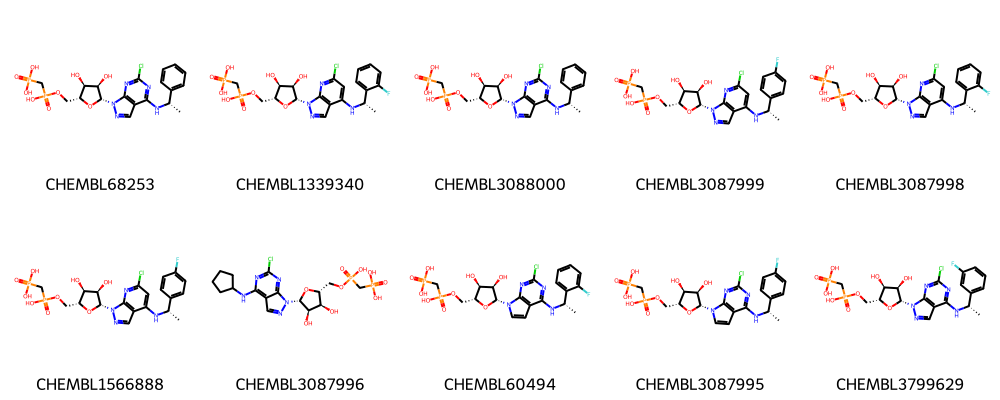

In [20]:
#show with rdkit the image of the 5 molecules with more pIC50
from rdkit import Chem
from rdkit.Chem import Draw

# Ordina il DataFrame in base a pIC50 in modo decrescente e seleziona le prime 5 righe
top10_molecules = df_final.sort_values('pIC50', ascending=False).head(10)

molecules = []
for smiles, chembl_id in zip(top10_molecules['canonical_smiles'], top10_molecules['molecule_chembl_id']):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is not None:
        molecules.append(molecule)

Draw.MolsToGridImage(molecules[:10], molsPerRow=5, subImgSize=(200, 200), legends=[str(i) for i in df_final['molecule_chembl_id'][:10]])



In [21]:
df_final.to_csv('cd73_bioactivity_data_preprocessed.csv', index=False)

Save eberything in a smi to activate the padel descriptor

In [22]:
selection = ['canonical_smiles','molecule_chembl_id']
df_smi = df_final[selection]
df_smi.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [23]:
# for windows users use the bash
#cd C:\Users\franc\BTS\Projects\CD73_analyzer\PaDEL-Descriptor
#cd path of your PaDEL-Descriptor 
# java -Xms1G -Xmx1G -Djava -jar PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes PubchemFingerprinter.xml -dir C:\Users\franc\BTS\Projects\CD73_analyzer -file descriptors_output.csv
#java -Xms1G -Xmx1G -Djava -jar PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes PubchemFingerprinter.xml -dir [path for your smi file] -file name.csv
